In [3]:
%pylab inline
%gui qt

Populating the interactive namespace from numpy and matplotlib


In [8]:
import seaborn as sns
from spiketag.mvc.Control import controller
from spiketag.base import probe
from spiketag.analysis import place_field

In [6]:
mua_filename = './mua.bin'
spk_filename = './spk.bin'
prb_filename = './sorting/dusty.json'

In [7]:
prb = probe()
prb.load(prb_filename)

## Correct time drift

In [9]:
start_time = 2.24
end_time   = 2500

In [10]:
ctrl = controller(
                  fpga = True,
                  probe = prb,
                  mua_filename=mua_filename, 
                  spk_filename=spk_filename, 
                  binary_radix=13, 
                  scale=False,
                  
#                   pc=pc, bin_size=4, v_cutoff=20,
#                   behavior_start_time = start_time,
#                   sort_movment_only = True,
                  
#                   spktag_filename = './spktag/test_allspikes',
                  time_segs=[[320, end_time]]
                 )

2019-11-02 11:48:46,497 - spiketag - INFO - load mua data
2019-11-02 11:48:46,714 - spiketag - INFO - #############  load data  ###################
2019-11-02 11:48:46,715 - spiketag - INFO - ./mua.bin loaded, it contains: 
2019-11-02 11:48:46,715 - spiketag - INFO - 63843580.0 * 160 points (40859891200 bytes) 
2019-11-02 11:48:46,716 - spiketag - INFO - 160 channels with sampling rate of 25000.0000 
2019-11-02 11:48:46,717 - spiketag - INFO - 2553.743 secs (42.562 mins) of data
2019-11-02 11:48:46,717 - spiketag - INFO - #############################################
2019-11-02 11:48:46,718 - spiketag - INFO - processing folder: ./
2019-11-02 11:48:46,803 - spiketag - INFO - raw data have 1392303 spks
2019-11-02 11:48:46,804 - spiketag - INFO - ----------------success------------------
2019-11-02 11:48:46,805 - spiketag - INFO -  
2019-11-02 11:48:46,806 - spiketag - INFO - extract spikes from pivital meta data
2019-11-02 11:48:46,807 - spiketag - INFO - mua.tospk() with time_cutoff=Tr

In [11]:
ctrl.show()

2019-11-02 11:49:27,797 - spiketag - INFO - clustering with dpgmm
2019-11-02 11:49:27,830 - spiketag - INFO - Model.spktag is generated, nspk:1233503


<function cluster._dpgmm at 0x7f643b7b9ea0>
{'n_comp': 4}
39 [0 3 2 ... 3 2 1]
39 cluster finished


In [12]:
clk = ctrl.spk_time[0]

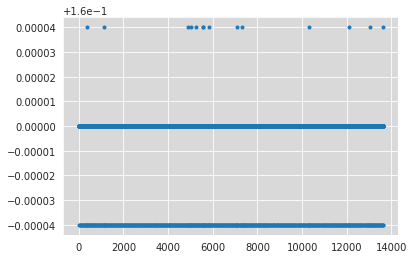

In [15]:
plot(np.diff(clk), '.')

In [16]:
right_clk = np.arange(clk[0], clk[0]+160e-3*clk.shape[0], 160e-3)

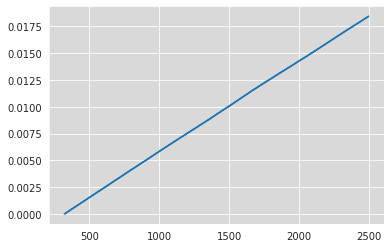

In [17]:
plot(right_clk, right_clk - clk)

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
regr = LinearRegression()
regr.fit(clk.reshape(-1,1), right_clk.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
def convert_time(timearray):
    return regr.predict(timearray.reshape(-1,1)).ravel()

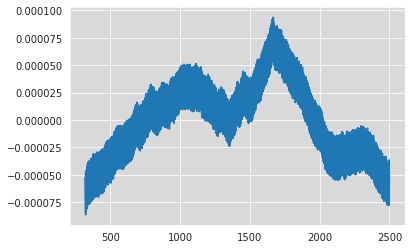

In [21]:
plot(right_clk, right_clk - convert_time(clk))

In [22]:
regr.intercept_, regr.coef_

(array([-0.00265503]), array([[1.00000846]]))

## Load decoded position

In [28]:
val = np.fromfile('./decoded_pos.bin').reshape(-1,3)

In [29]:
ts = val[:,0]*25e-3
pos = val[:, 1:]

In [30]:
new_ts = convert_time(ts)

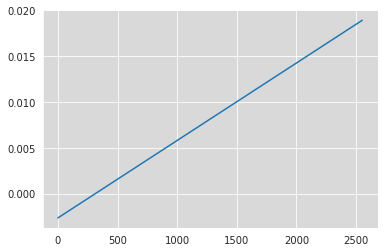

In [33]:
plot(new_ts, new_ts-ts)

In [35]:
pc = place_field(pos, new_ts, v_cutoff=25)

In [36]:
pc(33.333e-3)
pc.initialize(bin_size=4, v_cutoff=25)
pc.align_with_recording(320, 2500, 2.24)

In [37]:
gt_pos = np.fromfile('./sorting/dusty_pos.bin').reshape(-1,2)
gt_pc = place_field(gt_pos, t_step=33.333e-3)
gt_pc.initialize(bin_size=4, v_cutoff=25)
gt_pc.align_with_recording(320, 2500, 2.003)

In [55]:
from spiketag.analysis import smooth
from sklearn.metrics import r2_score

In [71]:
span=50000

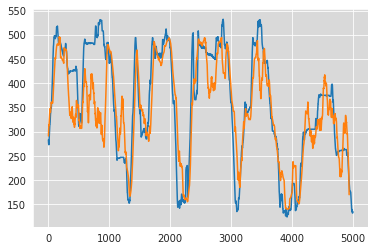

In [53]:
plot(gt_pc.pos[:span
               
               ,0])
plot(smooth(pc.pos[:span
                  
                  ],60)[60:,0])

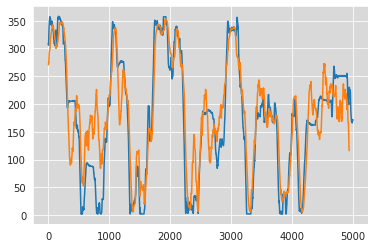

In [54]:
plot(gt_pc.pos[:span,1])
plot(smooth(pc.pos[:span],60)[60:,1])

In [384]:
def score_rt_decoding(gt_pc, pc, span, smooth_factor, v_cutoff):
    _gt_pos = gt_pc.pos.copy()[:span]
    _rt_pos = pc.pos.copy()[:span+smooth_factor]
    v = np.linalg.norm(np.diff(_gt_pos, axis=0), axis=1)/np.diff(gt_pc.ts[:span])
    v = np.hstack((0, v))
    v_smoothed = smooth(v.reshape(-1,1), smooth_factor).ravel()
    idx = np.where(v_smoothed>v_cutoff)[0]
    _gt_pos = _gt_pos[idx]
    _rt_pos = smooth(_rt_pos, smooth_factor)[smooth_factor:]
    _rt_pos = _rt_pos[idx]
    _gt_pos -= np.mean(_gt_pos, axis=0)
    _rt_pos -= np.mean(_rt_pos, axis=0)
    _gt_pos /= 3
    _rt_pos /= 3
    score = r2_score(_gt_pos[:span], 
                     _rt_pos[:span], multioutput='raw_values')
    fig, ax = plt.subplots(1,2,figsize=(15,4))
    N = _gt_pos[:span].shape[0]
    print('N={}'.format(N))
    ts = np.linspace(0, N*33.333e-3, N)
    for i in [0,1]:
        ax[i].plot(ts, _gt_pos[:span, i],  label='actual', lw=4, alpha=.4)
        ax[i].plot(ts, _rt_pos[:span, i],  label='decoded')
        ax[i].legend(loc='upper right')
        ax[i].set_xlabel('time (secs)')
        ax[i].set_title('r2 score:{0:.3f}'.format(score[i]))
        ax[i].set_ylim([-80, 100])
    ax[0].set_ylabel('2D maze x-axis (cm)')
    ax[1].set_ylabel('2D maze y-axis (cm)')
    sns.despine()
    return score, fig

N=4272


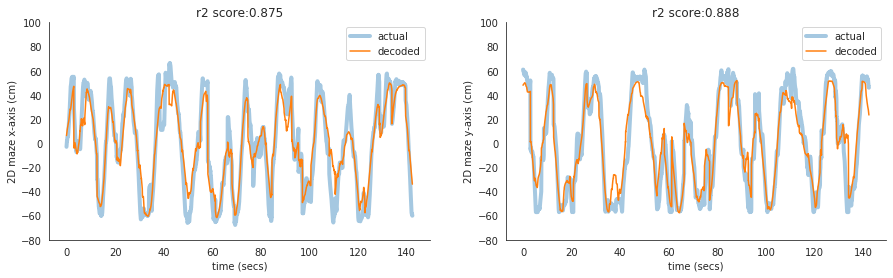

In [385]:
sns.set_style('white')
s,f = score_rt_decoding(gt_pc, pc, span=10000, smooth_factor=85, v_cutoff=75)

In [387]:
f.savefig('./real_time_dec_result.pdf')